# Image Augmentation

In order to create more balanced images, we perform some image augmentation to create additional images.

We need to be a bit conservative in our augmentation :
- Conservative rotations (±15° max)
- Subtle color adjustments
- Preserved anatomical structures
- Gaussian blur for different focus conditions

In [1]:
! pip install torch torchvision pillow matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 MB 11.6 MB/s  0:00:06m0:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.9.1
    Uninstalling torch-2.9.1:━━━━━━━━━━━━━━━━━━━ 0/2 [torch]
      Successfully uninstalled torch-2.9.1━━ 0/2 [torch]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchvision] [torchvision]


In [19]:
import os
import cv2
from matplotlib import pyplot as plt
def display_images(image_filenames:list[str], title="Image DataSet", col_count = 10):
    plt.suptitle(title, fontsize=10)
    img_count = len(image_filenames)
    plt.figure(figsize=(15, 15))
    for i in range(1, img_count+1):
        plt.subplot(5, col_count, i)
        image_path=image_filenames[i-1]
        image_name=os.path.basename(image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, aspect="auto")
        plt.title(f"{image_name}",fontsize=9)
        plt.axis(False)
    plt.show();

In [41]:
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from pathlib import Path

class ODIRAugmentor:
    """Augmentor specifically for ODIR-2019 eye fundus images"""
    
    def __init__(self, output_dir):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Define specific augmentations suitable for medical eye images
        self.augmentations = {
            'flip': transforms.RandomHorizontalFlip(p=1.0),
            'rotate': transforms.RandomRotation(degrees=(-15, 15)),
            'brightness': transforms.ColorJitter(brightness=0.2),
            'contrast': transforms.ColorJitter(contrast=0.2),
            'color': transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
            'blur': transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
        }
        
        # Combinations that work well for fundus images
        self.presets = {
            'basic': ['flip', 'rotate'],
            'color_variation': ['brightness', 'contrast', 'rotate'],
            'geometric': ['flip'],
            'full': ['flip', 'rotate', 'color','brightness','contrast','blur'],
        }
    
    def create_augmentations(self, image_path, num_images=8, preset='full'):
        """
        Create augmented images using a preset combination
        """
        image = Image.open(image_path).convert('RGB')
        original_name = Path(image_path).stem
        original_ext = Path(image_path).suffix
        
        # Get augmentation list for preset
        aug_list = self.presets[preset]
        
        output_paths=[]
        # Save original
        original_filename=f"{original_name}{original_ext}"
        original_path = os.path.join(self.output_dir, original_filename)
        image.save(original_path)
        output_paths.append({"path":original_path,"augmentations":"[]","filename":original_filename})
        # Create transformations
        for i in range(num_images):
            transform_list = []
            
            # Randomly select 2-3 augmentations from the preset
            num_augs = np.random.randint(2, min(4, len(aug_list) + 1))
            selected_augs = np.random.choice(aug_list, num_augs, replace=False)
            
            for aug_name in selected_augs:
                transform_list.append(self.augmentations[aug_name])
                        
            # Create transform
            transform = transforms.Compose(transform_list)
            
            # Apply and save
            augmented = transform(image)
            output_filename = f"{original_name}_a_{i+1:02d}{original_ext}"
            output_path = os.path.join(
                self.output_dir, 
                output_filename
            )
            augmented.save(output_path)
            output_paths.append({"filename":output_filename,"augmentations":f"{selected_augs}","path":output_path})
        return output_paths

<Figure size 640x480 with 0 Axes>

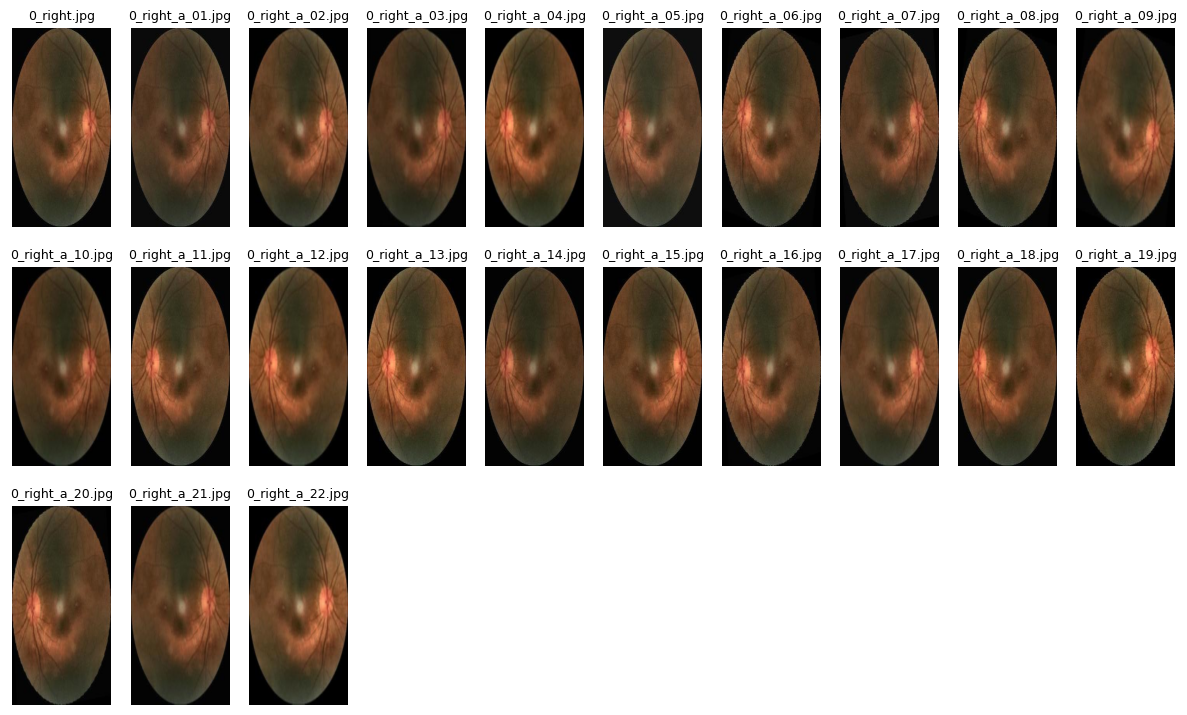

,path,augmentations,filename
0,ODIR-2019/augmented_images/0_right.jpg,[],0_right.jpg
1,ODIR-2019/augmented_images/0_right_a_01.jpg,['contrast' 'brightness'],0_right_a_01.jpg
2,ODIR-2019/augmented_images/0_right_a_02.jpg,['blur' 'brightness' 'color'],0_right_a_02.jpg
3,ODIR-2019/augmented_images/0_right_a_03.jpg,['brightness' 'blur' 'rotate'],0_right_a_03.jpg
4,ODIR-2019/augmented_images/0_right_a_04.jpg,['contrast' 'flip' 'blur'],0_right_a_04.jpg
5,ODIR-2019/augmented_images/0_right_a_05.jpg,['brightness' 'flip' 'contrast'],0_right_a_05.jpg
6,ODIR-2019/augmented_images/0_right_a_06.jpg,['rotate' 'flip'],0_right_a_06.jpg
7,ODIR-2019/augmented_images/0_right_a_07.jpg,['contrast' 'rotate' 'color'],0_right_a_07.jpg
8,ODIR-2019/augmented_images/0_right_a_08.jpg,['flip' 'rotate'],0_right_a_08.jpg
9,ODIR-2019/augmented_images/0_right_a_09.jpg,['blur' 'rotate'],0_right_a_09.jpg


In [52]:
import pandas as pd
input_folder="ODIR-2019/processed_images"
output_folder="ODIR-2019/augmented_images"
input_image=f"{input_folder}/0_right.jpg"
augmentor = ODIRAugmentor(output_dir=output_folder)
images=augmentor.create_augmentations(image_path=input_image, num_images=22)
image_paths = [k["path"] for k in images  ]
display_images(image_paths,"augmented images")
images_df = pd.DataFrame(images)
images_df

We can see that we managed to augment our image with additional 8 images

Next we need to adjust for each category in our training dataset to create a balanced dataset and update our dataset

From our EDA we have the following 
```
Train Data Set Output
label
N    2112
D    1201
O     511
G     211
A     199
C     199
M     172
H      96
```
We aim to make each category more or less close to Normal category. Hence, we can calculate a ratio of augmented data

Ratio for D = Size of N / Size of D = 2112 / 1201 = 1.75 for each image in D we need another image, capped at 2112

Hence our algorithm will first find extra image needed for each image in a category and then cap it 


In [51]:
train_df = pd.read_csv('ODIR-2019/results/01_eda_train_df.csv')
vc=train_df['label'].value_counts()
print(2112/96)

22.0
